# Interactive peak search
Try running it in a live notebook for animation!

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightlab.util.sweep as sUtil

In [2]:
livePlots = False

Text(0.5,1,'Poor, low-res sampling of underlying peak')

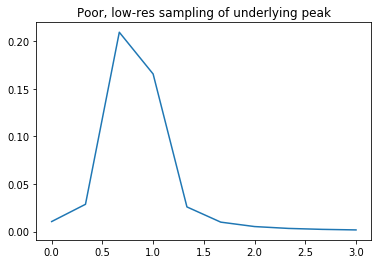

In [3]:
center = .82
amp = .7
fwhm = .2
def myPeakedFun(x):
    noise = amp * 1e-2
    y = amp / (1 + (2 * (x - center) / fwhm) ** 2) + noise * np.random.randn()
    return y
xq = np.linspace(0,3, 10)
plt.plot(xq, myPeakedFun(xq))
plt.title('Poor, low-res sampling of underlying peak')

In [4]:
xPeak, yPeak = sUtil.peakSearch(evalPointFun=myPeakedFun, startBounds=[0,3],
                         nSwarm=3, xTol=.001, livePlot=livePlots)
assert abs(xPeak - center) < .1
assert abs(yPeak - amp) < .1

Detected positive curvature
Converged on peak


## Interactive peak descent through binary search

In [5]:
rightBounds = [xPeak, 3]
leftBounds = [0, xPeak]
xRightHalf = sUtil.binarySearch(evalPointFun=myPeakedFun, targetY=0.5*yPeak, 
                                startBounds=rightBounds,
                                xTol=.001,
                                livePlot=livePlots)
xLeftHalf = sUtil.binarySearch(evalPointFun=myPeakedFun, targetY=0.5*yPeak, 
                                startBounds=leftBounds,
                                xTol=.001,
                                livePlot=livePlots)
assert abs(xLeftHalf - (center - fwhm/2)) < .1
assert abs(xRightHalf - (center + fwhm/2)) < .1